# Variantional Autoencoder (VAE)

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
sess = tf.Session()

In [4]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    l_border = -constant * np.sqrt(6.0 / (fan_in + fan_out)) 
    h_border = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval=l_border, maxval=h_border, dtype=tf.float32)

In [5]:
def fc_layer(name, prev, W, b, type):
    activ = {
        'relu': tf.nn.relu,
        'softmax': tf.nn.softmax,
        'sigmoid': tf.nn.sigmoid,
        'identity': tf.identity
    }
    
    with tf.variable_scope(name):
        prev = tf.matmul(prev, tf.Variable(W, name='W'), name='fc')
        prev = tf.nn.bias_add(prev, tf.Variable(b, name='b'), name='bias')
        prev = activ[type](prev, name='relu')
    return prev

In [6]:
h_image, w_image = 28, 28 
n_input = h_image * w_image

In [7]:
batch_size = 100

In [8]:
class VAE():
    def __init__(self, n_input, n_latent, batch_size):
        self.n_input = n_input
        self.n_latent = n_latent
        
        self.t_input = tf.placeholder(tf.float32, [None, n_input])
        
        with tf.variable_scope('encoder'):
            self.t_mu, self.t_sigma_log_sq = self.__encoder(self.t_input)
            
        eps = tf.random_normal([batch_size, n_latent], 0, 1, dtype=tf.float32)
        self.t_latent = tf.add(self.t_mu, tf.mul(tf.exp(0.5 * self.t_sigma_log_sq), eps))
            
        with tf.variable_scope('decoder'):
            self.t_mu_hat, self.t_sigma_log_sq_hat = self.__decoder(self.t_latent)
            
        eps = tf.random_normal([batch_size, n_input], 0, 1, dtype=tf.float32)
        self.t_reconstr = tf.sigmoid(tf.add(self.t_mu_hat, tf.mul(tf.exp(0.5 * self.t_sigma_log_sq_hat), eps)))
            
        self.t_cost, self.t_train = self.__loss()
    
    def __encoder(self, prev):
        W = xavier_init(self.n_input, 500)
        b = tf.zeros([500], dtype=tf.float32)
        prev = fc_layer('fc1', prev, W=W, b=b, type='relu')
    
        W = xavier_init(500, 500)
        b = tf.zeros([500], dtype=tf.float32)
        prev = fc_layer('fc2', prev, W=W, b=b, type='relu')
        
        W_mu = xavier_init(500, self.n_latent)
        b_mu = tf.zeros([self.n_latent], dtype=tf.float32)
        t_mu = fc_layer('mean', prev, W=W_mu, b=b_mu, type='identity')

        W_sigma_log_sq = xavier_init(500, self.n_latent)
        b_sigma_log_sq = tf.zeros([self.n_latent], dtype=tf.float32)
        t_sigma_log_sq = fc_layer('sigma_log', prev, W=W_sigma_log_sq, b=b_sigma_log_sq, type='identity')
        
        return t_mu, t_sigma_log_sq
    
    def __decoder(self, prev):
        W = xavier_init(self.n_latent, 500)
        b = tf.zeros([500], dtype=tf.float32)
        prev = fc_layer('fc1', prev, W=W, b=b, type='relu')
    
        W = xavier_init(500, 500)
        b = tf.zeros([500], dtype=tf.float32)
        prev = fc_layer('fc2', prev, W=W, b=b, type='relu')
        
        W_mu = xavier_init(500, self.n_input)
        b_mu = tf.zeros([self.n_input], dtype=tf.float32)
        t_mu = fc_layer('mean', prev, W=W_mu, b=b_mu, type='identity')

        W_sigma_log_sq = xavier_init(500, self.n_input)
        b_sigma_log_sq = tf.zeros([self.n_input], dtype=tf.float32)
        t_sigma_log_sq = fc_layer('sigma_log', prev, W=W_sigma_log_sq, b=b_sigma_log_sq, type='identity')
        
        return t_mu, t_sigma_log_sq
    
    def __loss(self):
        eps = 1e-7
        a = -0.5 * self.n_input * tf.exp(tf.reduce_sum(self.t_sigma_log_sq_hat, 1))
        b = -0.5 * tf.reduce_sum(tf.mul(
                tf.div(
                    self.t_input - self.t_mu_hat,
                    tf.exp(self.t_sigma_log_sq_hat) + eps
                ),
                self.t_input - self.t_mu_hat
            ), 1)
        c = -0.5 * np.log(2.0 * np.pi)
        
        t_loss_reconstr = -(a + b + c)
        t_loss_regular = -0.5 * tf.reduce_sum(
            1.0 + self.t_sigma_log_sq - tf.square(self.t_mu) - tf.exp(self.t_sigma_log_sq), 1)
        
        t_cost = tf.reduce_mean(t_loss_reconstr + t_loss_regular)
        t_train = tf.train.AdamOptimizer(learning_rate=1e-5).minimize(t_cost)
        
        return t_cost, t_train

In [9]:
vae_20 = VAE(n_input, 20, batch_size)

In [10]:
def fit(vae, n_epochs):
    init = tf.initialize_all_variables()
    sess.run(init)
    total_batch = int(n_samples / batch_size)
    
    for epoch in range(n_epochs):
        avg_cost = 0.0
    
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            _, cost = sess.run([vae.t_train, vae.t_cost], feed_dict={vae.t_input: batch_xs})
            avg_cost += cost / n_samples * batch_size

        if epoch % 5 == 0:
            print "Epoch: %04d" % (epoch+1), "cost = {:.9f}".format(avg_cost)

In [11]:
fit(vae_20, 125)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0001 cost = 1422.435683726
Epoch: 0006 cost = 32.236388942
Epoch: 0011 cost = 30.061540826
Epoch: 0016 cost = 29.289927094
Epoch: 0021 cost = 26.376356933
Epoch: 0026 cost = 18.816041079
Epoch: 0031 cost = 12.039896473
Epoch: 0036 cost = 7.542349473
Epoch: 0041 cost = 5.201879729
Epoch: 0046 cost = 4.385025925
Epoch: 0051 cost = 3.990259476
Epoch: 0056 cost = 3.672122136
Epoch: 0061 cost = 3.440683115
Epoch: 0066 cost = 3.260746336
Epoch: 0071 cost = 3.106264572
Epoch: 0076 cost = 2.985257371
Epoch: 0081 cost = 2.871340021
Epoch: 0086 cost = 2.788182392
Epoch: 0091 cost = 2.692115945
Epoch: 0096 cost = 2.607268998
Epoch: 0101 cost = 2.534535750
Epoch: 0106 cost = 2.463799207
Epoch: 0111 cost = 2.405645568
Epoch: 0116 cost = 2.349493589
Epoch: 0121 cost = 2.295530777


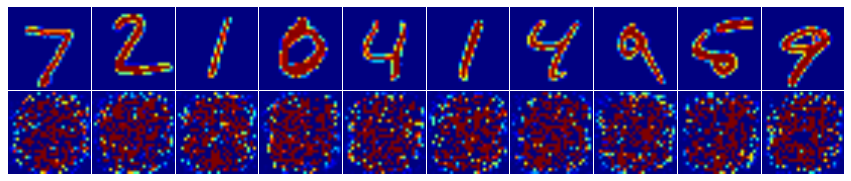

In [12]:
def draw_image(image, ax):
    ax.imshow(image, vmin=0, vmax=1)
    ax.tick_params(
        axis='both', which='both',
        bottom='off', top='off', right='off', left='off',
        labelbottom='off', labelleft='off'
    )
    for spine in ax.spines.values():
        spine.set_edgecolor('#ffffff')

sample, _ = mnist.test.next_batch(100)
sample_re = sess.run(vae_20.t_reconstr, feed_dict={vae_20.t_input: sample})

f, axarr = plt.subplots(2, 10, figsize=(15, 3))
f.subplots_adjust(wspace=0, hspace=0)

for i in range(10):
    draw_image(sample[i].reshape(h_image, w_image), axarr[0, i])
    draw_image(sample_re[i].reshape(h_image, w_image), axarr[1, i])
